In [2]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel, TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase all words
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize words
    words = word_tokenize(text)
    # Remove stop words and short words
    words = [word for word in words if word not in stop_words and len(word) > 2]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

In [11]:
# Load CSV data
data = pd.read_csv('data/train_set.csv')
data = data.groupby(['Subreddit']).apply(lambda x: x.sample(frac=0.15, random_state=100)).reset_index(drop=True)
data.shape

(119374, 4)

In [12]:
documents = data['Post'].tolist()
documents = [preprocess(doc) for doc in documents]

In [29]:
# Create a dictionary
dictionary = corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=10, no_above=0.2, keep_n=50000)

In [31]:
# Create a corpus
corpus = [dictionary.doc2bow(doc) for doc in documents]
tfidf_model = TfidfModel(corpus)

# Create a gensim TF-IDF corpus
tfidf_corpus = tfidf_model[corpus]

In [32]:
# Train the LDA model
lda_model = LdaModel(corpus=tfidf_corpus,
                     id2word=dictionary,
                     num_topics=5, # Change this to the number of topics you want
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

In [33]:
# Print the top topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.008*"idk" + 0.008*"scared" + 0.007*"whenever" + 0.007*"tip" + 0.007*"extremely" + 0.006*"comfortable" + 0.006*"sleep" + 0.006*"interaction" + 0.006*"super" + 0.006*"struggling"
Topic: 1 
Words: 0.053*"phone" + 0.046*"quiet" + 0.027*"coworkers" + 0.022*"door" + 0.019*"alot" + 0.018*"rid" + 0.015*"urge" + 0.014*"planning" + 0.013*"possibly" + 0.012*"drop"
Topic: 2 
Words: 0.012*"social" + 0.010*"people" + 0.009*"anxiety" + 0.008*"friend" + 0.008*"talk" + 0.006*"make" + 0.006*"someone" + 0.006*"always" + 0.006*"say" + 0.005*"help"
Topic: 3 
Words: 0.009*"anxious" + 0.006*"advice" + 0.006*"nervous" + 0.005*"experience" + 0.004*"health" + 0.004*"reason" + 0.004*"afraid" + 0.004*"parent" + 0.004*"wan" + 0.004*"depression"
Topic: 4 
Words: 0.006*"said" + 0.006*"job" + 0.005*"also" + 0.005*"anxiety" + 0.005*"therapy" + 0.005*"school" + 0.005*"class" + 0.004*"ive" + 0.004*"actually" + 0.004*"therapist"


In [34]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(tfidf_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.716824369235109

Coherence Score:  0.2653877718233904


In [35]:
# Create a dictionary of word frequencies for each topic
topic_word_freqs = {}
for topic_id in range(5):
    topic_word_freqs[topic_id] = dict(lda_model.show_topic(topic_id, topn=50))

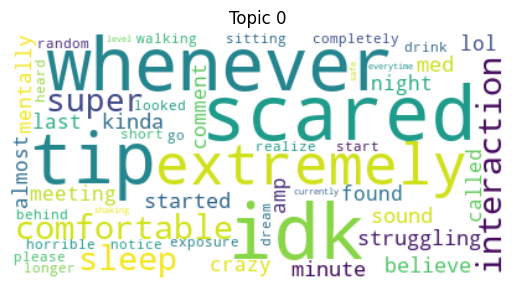

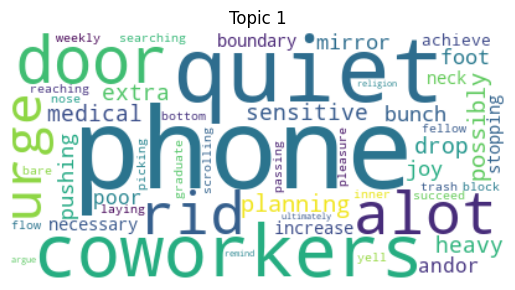

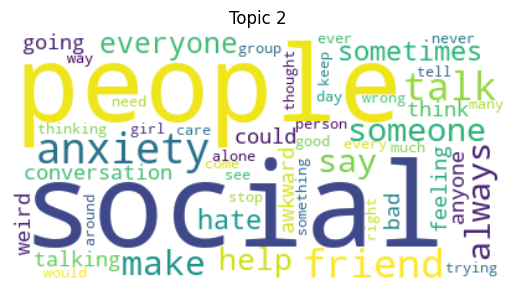

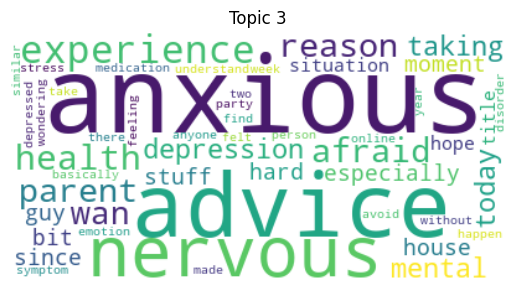

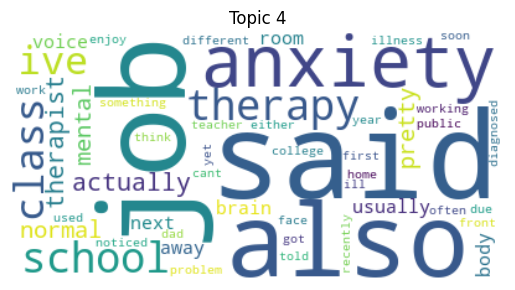

In [36]:
# Create word clouds for each topic
for topic_id in range(5):
    wordcloud = WordCloud(background_color='white').fit_words(topic_word_freqs[topic_id])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_id}")
    plt.show()

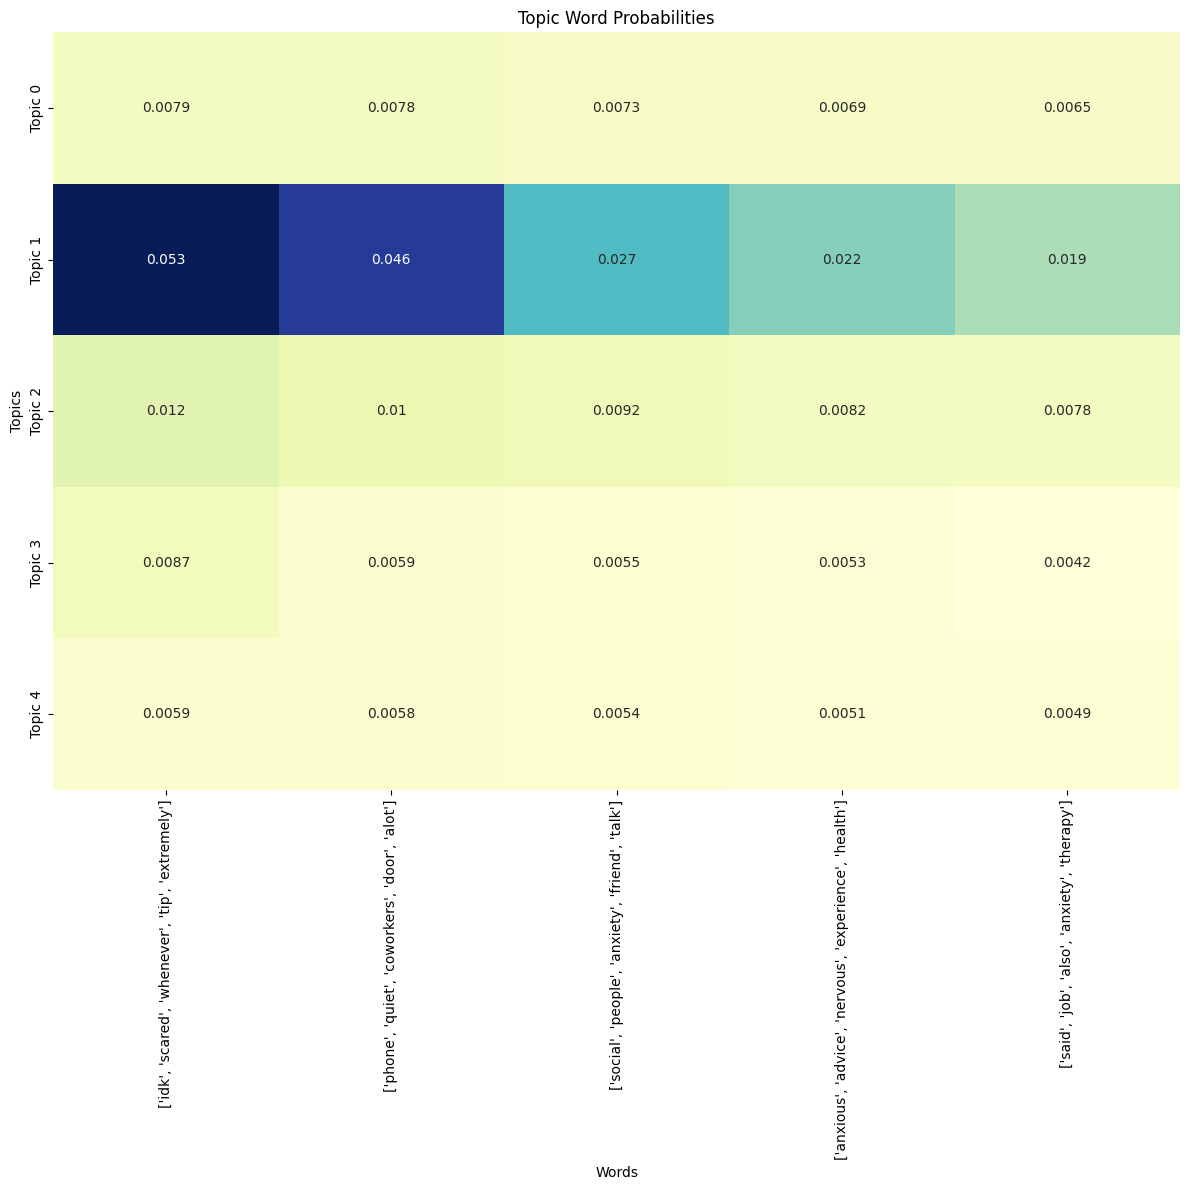

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Assuming you have an LdaModel object named lda_model and a Gensim dictionary named dictionary

num_topics = lda_model.num_topics
num_words = 5

# Get the top N words for each topic
topic_words = []
for topic in range(num_topics):
    top_words = lda_model.show_topic(topic, num_words)
    topic_words.append([word for word, _ in top_words])

# Create a heatmap of word probabilities per topic
word_probabilities = []
for topic in range(num_topics):
    word_probs = []
    for word, probability in lda_model.show_topic(topic, num_words):
        word_probs.append(probability)
    word_probabilities.append(word_probs)

plt.figure(figsize=(12, 12))
sns.heatmap(word_probabilities, annot=True, cmap="YlGnBu", cbar=False, xticklabels=topic_words, yticklabels=["Topic {}".format(i) for i in range(num_topics)])

plt.xlabel("Words")
plt.ylabel("Topics")
plt.title("Topic Word Probabilities")
plt.tight_layout()
plt.show()

In [48]:
for topic in range(num_topics):
    top_words = lda_model.show_topic(topic, 10)
    print(top_words)

[('idk', 0.007855677), ('scared', 0.007814874), ('whenever', 0.007324754), ('tip', 0.006884365), ('extremely', 0.0065358724), ('comfortable', 0.006498632), ('sleep', 0.0064221635), ('interaction', 0.006303874), ('super', 0.0058512115), ('struggling', 0.0057265265)]
[('phone', 0.052923165), ('quiet', 0.0458291), ('coworkers', 0.027164796), ('door', 0.021897344), ('alot', 0.018757295), ('rid', 0.018189887), ('urge', 0.015061572), ('planning', 0.013589185), ('possibly', 0.013376691), ('drop', 0.012417131)]
[('social', 0.01241353), ('people', 0.010190855), ('anxiety', 0.00922421), ('friend', 0.008168574), ('talk', 0.007846385), ('make', 0.006458946), ('someone', 0.0059583653), ('always', 0.005860314), ('say', 0.0057107713), ('help', 0.0050493586)]
[('anxious', 0.008684644), ('advice', 0.005856685), ('nervous', 0.0055021886), ('experience', 0.005271431), ('health', 0.0041868263), ('reason', 0.0039568497), ('afraid', 0.003940811), ('parent', 0.0039071827), ('wan', 0.0037542712), ('depression